In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:51: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [5]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:275: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:275: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')
sector_rtns['All']=np.log(cleansed.resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """


In [8]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,3)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,3)

tsmom_model.py:240: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:241: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [9]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


In [10]:
factors.mean()

Agriculturals    0.002664
All              0.003378
Currencies       0.002047
Energies         0.003738
Equities         0.000972
Metals          -0.002278
Fixed Income     0.000620
dtype: float64

In [11]:
final_res=pd.DataFrame()
betas_res=pd.DataFrame()
alpha={}
tstat={}
for sec in factors.columns:
    ind=factors.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    #reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AA']=res.params *100
        betas_res['AA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha1']=pd.Series(alpha)*100
final_res['tstat']=pd.Series(tstat)

# FHT Annual portfolio sorts

In [12]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:288: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:289: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:290: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:290: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [13]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,3)
sector_portfolio_sorts['All']=quantile_portfolios_annual(FHT,cleansed,3)

In [14]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['2']-sector_portfolio_sorts[s]['0']


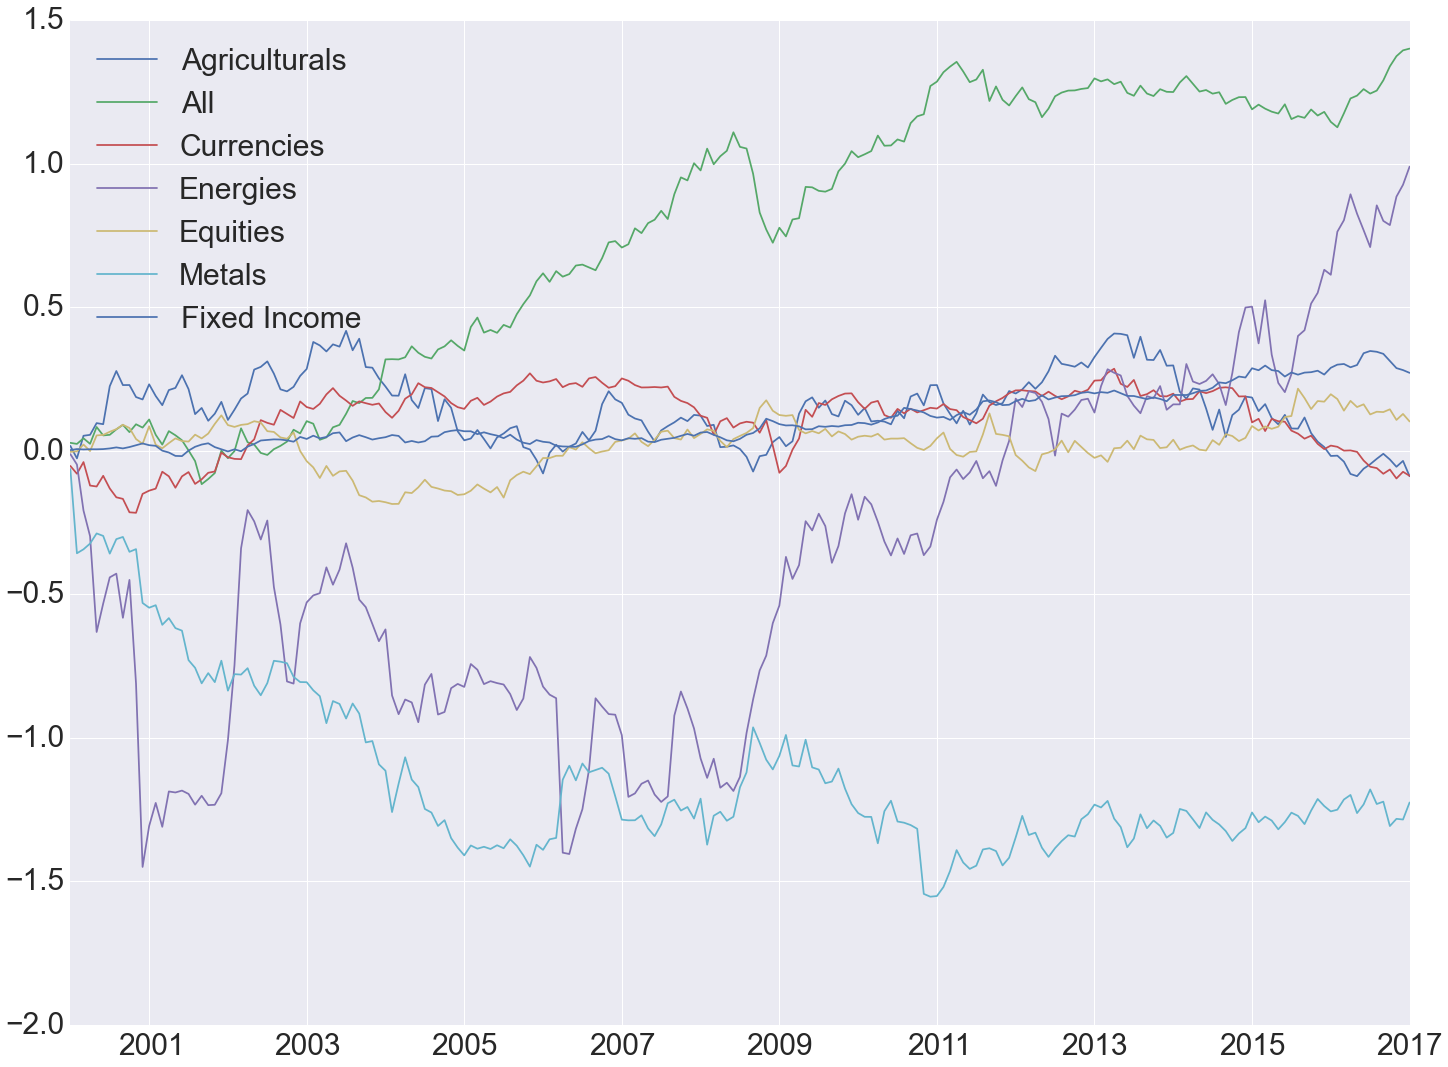

In [15]:
factors_FHT['2000':].cumsum().plot()

In [16]:
alpha={}
tstat={}
for sec in factors_FHT.columns:
    ind=factors_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    #reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_FHT[sec]['2000':'2016'],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FA']=res.params  *100
        betas_res['FA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha F-A']=pd.Series(alpha)*100
final_res['tstat2']=pd.Series(tstat)

In [17]:
final_res

,alpha1,tstat,alpha F-A,tstat2
Agriculturals,0.327929,1.071208,-0.010109,-0.036998
All,0.317782,2.105347,0.455086,3.360915
Currencies,0.211361,1.060999,-0.026198,-0.139285
Energies,0.433662,0.670086,0.686426,0.766177
Equities,0.050345,0.252902,0.143959,0.868595
Fixed Income,0.066039,0.913798,0.048452,1.078736
Metals,-0.367800,-1.219548,-0.464843,-1.174036


# Monthly portoflio sorts

In [18]:
amihud_monthly = read_monthly(amihud=True,sorts=3)

In [19]:
factors_monthly=pd.DataFrame()
for s in amihud_monthly.keys():
    factors_monthly[s]=amihud_monthly[s]['2']-amihud_monthly[s]['0']


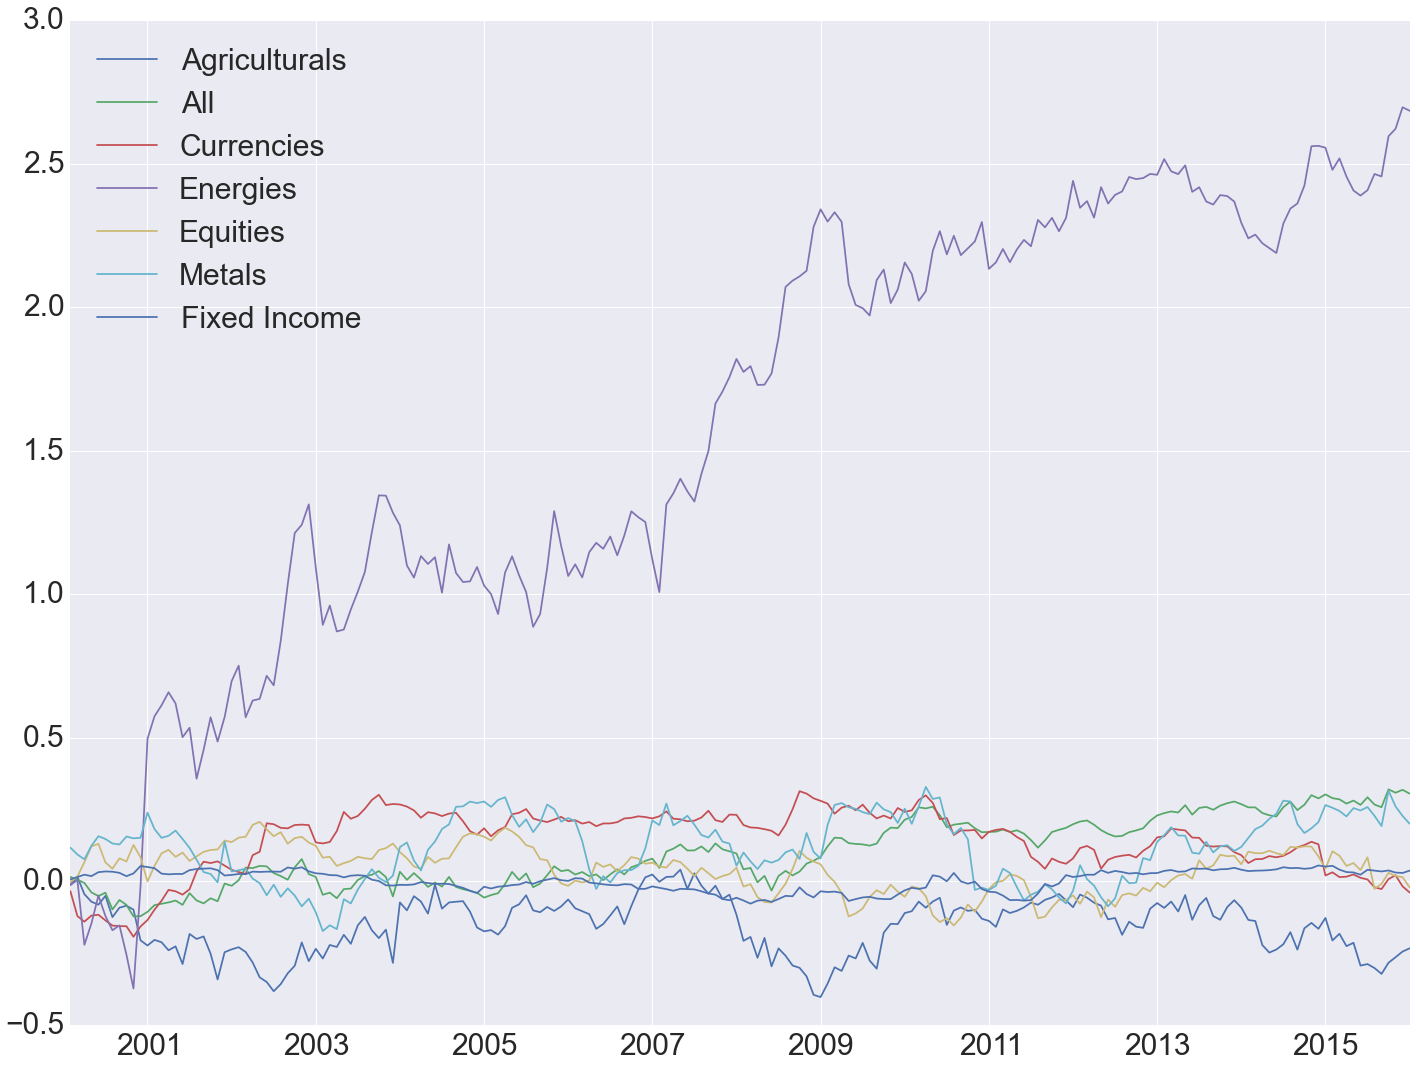

In [20]:
factors_monthly.cumsum().plot()

In [21]:
alpha={}
tstat={}
for sec in factors_monthly.columns:
    ind=factors_monthly['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    #reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_monthly[sec].loc[ind],reges.loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AM']=res.params  *100
        betas_res['AM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha A-M']=pd.Series(alpha)*100
final_res['tstat3']=pd.Series(tstat)

In [22]:
final_res

,alpha1,tstat,alpha F-A,tstat2,alpha A-M,tstat3
Agriculturals,0.327929,1.071208,-0.010109,-0.036998,-0.053501,-0.191478
All,0.317782,2.105347,0.455086,3.360915,0.185667,1.172691
Currencies,0.211361,1.060999,-0.026198,-0.139285,-0.087489,-0.462796
Energies,0.433662,0.670086,0.686426,0.766177,1.503111,1.903344
Equities,0.050345,0.252902,0.143959,0.868595,0.032499,0.141452
Fixed Income,0.066039,0.913798,0.048452,1.078736,0.042943,0.573246
Metals,-0.367800,-1.219548,-0.464843,-1.174036,0.079933,0.258609


# Monthly FHT

In [23]:
FHT_monthly = read_monthly(amihud=False,sorts=3)

In [24]:
factors_monthly_FHT=pd.DataFrame()
for s in FHT_monthly.keys():
    factors_monthly_FHT[s]=FHT_monthly[s]['2']-FHT_monthly[s]['0']


In [31]:
alpha={}
tstat={}
for sec in factors_monthly_FHT.columns:
    ind=factors_monthly_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    #reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')
    res=sm.OLS(factors_monthly_FHT[sec].loc[ind],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FM']=res.params  *100
        betas_res['FM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['alpha F-M']=pd.Series(alpha)*100
final_res['tstat4']=pd.Series(tstat)

In [33]:
betas_res

,AA,AA_T,FA,FA_T,AM,AM_T,FM,FM_T
VAL,11.183606,1.028462,-5.790802,-0.649487,0.745070,0.050513,-20.092948,-1.487124
MOM,-0.214238,-0.021579,-8.486542,-1.120680,-12.629002,-1.126864,-17.788913,-1.608594
Market Return,-5.407824,-0.848338,123.980534,12.966390,2.325153,0.329379,22.348132,3.151224
const,0.317782,2.105347,0.455086,3.360915,0.185667,1.172691,0.045025,0.284332


# Alpha values 

$$r_{liquidity,t} = \alpha + \beta_1 r_{AssetClass,t} + \beta_2 MOM_{AssetClass,t} +
\beta_3 VAL_{AssetClass,t} + \varepsilon_t $$

In [34]:
final_res.T['All'].round(2)

alpha1       0.32
tstat        2.11
alpha F-A    0.46
tstat2       3.36
alpha A-M    0.19
tstat3       1.17
alpha F-M    0.05
tstat4       0.28
Name: All, dtype: float64

In [42]:
print(final_res.T[[u'Agriculturals', u'Currencies', u'Energies', u'Equities',
       u'Fixed Income', u'Metals', u'All']].round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Fixed Income &  Metals &   All \\
\midrule
alpha1    &           0.33 &        0.21 &      0.43 &      0.05 &          0.07 &   -0.37 &  0.32 \\
tstat     &           1.07 &        1.06 &      0.67 &      0.25 &          0.91 &   -1.22 &  2.11 \\
alpha F-A &          -0.01 &       -0.03 &      0.69 &      0.14 &          0.05 &   -0.46 &  0.46 \\
tstat2    &          -0.04 &       -0.14 &      0.77 &      0.87 &          1.08 &   -1.17 &  3.36 \\
alpha A-M &          -0.05 &       -0.09 &      1.50 &      0.03 &          0.04 &    0.08 &  0.19 \\
tstat3    &          -0.19 &       -0.46 &      1.90 &      0.14 &          0.57 &    0.26 &  1.17 \\
alpha F-M &          -0.85 &        0.03 &      1.89 &      0.23 &         -0.03 &   -0.17 &  0.05 \\
tstat4    &          -2.77 &        0.14 &      2.86 &      1.07 &         -0.64 &   -0.53 &  0.28 \\
\bottomrule
\end{tabular}



In [29]:
print final_res.T[[u'Agriculturals', u'Currencies', u'Energies', u'Equities',
       u'Fixed Income', u'Metals', u'All']].round(2).to_latex()


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Fixed Income &  Metals &   All \\
\midrule
alpha1    &           0.28 &        0.08 &      0.59 &     -0.02 &          0.05 &    0.02 &  0.18 \\
tstat     &           1.09 &        0.54 &      0.95 &     -0.14 &          0.83 &    0.07 &  1.47 \\
alpha F-A &           0.14 &        0.10 &      0.45 &     -0.03 &          0.06 &    0.09 &  0.24 \\
tstat2    &           0.67 &        0.56 &      0.80 &     -0.20 &          1.39 &    0.30 &  2.33 \\
alpha A-M &           0.31 &       -0.05 &      0.84 &     -0.01 &          0.05 &    0.07 &  0.12 \\
tstat3    &           1.24 &       -0.30 &      1.41 &     -0.08 &          0.70 &    0.23 &  0.91 \\
alpha F-M &          -0.30 &        0.07 &      0.98 &      0.34 &          0.01 &   -0.01 &  0.04 \\
tstat4    &          -1.02 &        0.37 &      1.87 &      1.88 &          0.17 &   -0.02 &  0.30 \\
\bottomrule
\end{tabular}



# These results are so bad from the beta's to the factors point of view from all markets.  It's just way to high for FHT

I am not going to present them in the results.

In [43]:
print(betas_res.T.round(2)[['const','Market Return','VAL','MOM','TERM']].to_latex())

KeyError: "['TERM'] not in index"

# Adding additional factors

* TERM
* 

In [31]:
reges['TERM']=quandl.get('FRED/THREEFYTP10',authtoken=token).Value.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


In [34]:
betas_res

,AA,AA_T,FA,FA_T,AM,AM_T,FM,FM_T
VAL,4.894491,0.658063,-10.365014,-1.789100,1.830187,0.245592,-13.548865,-1.372981
MOM,-2.697738,-0.353982,-11.161096,-1.616071,-5.344737,-0.681562,-13.004126,-1.843249
Market Return,2.261443,0.421718,93.144699,11.578119,1.079371,0.204228,13.309223,2.644994
const,0.179068,1.467335,0.238169,2.331633,0.117758,0.914100,0.040309,0.301948
TERM,-0.044613,-0.237651,0.150633,1.047804,0.081865,0.416365,-0.084204,-0.421363


In [43]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:           Fixed Income   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     27.06
Date:                Fri, 17 Aug 2018   Prob (F-statistic):           6.18e-18
Time:                        16:28:13   Log-Likelihood:                 748.74
No. Observations:                 204   AIC:                            -1487.
Df Residuals:                     199   BIC:                            -1471.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
MOM_FI            0.0004      0.074      0.005

In [44]:
factors

,Agriculturals,All,Currencies,Energies,Equities,Metals,Fixed Income
2000-01-31,-0.055654,-0.010326,0.037552,-0.095232,0.012464,0.037483,-0.007752
2000-02-29,-0.003409,0.004095,0.031854,0.040961,0.029379,0.023852,-0.004405
2000-03-31,-0.008884,-0.007956,-0.001035,0.076088,-0.000987,-0.002141,-0.008619
2000-04-30,-0.003921,-0.006607,0.039218,0.126498,-0.034378,-0.009927,-0.003300
2000-05-31,-0.026950,-0.003539,0.001928,0.233571,-0.021745,0.019964,0.002273
2000-06-30,0.012682,0.002758,-0.049402,-0.119707,0.004284,0.048209,-0.000891
2000-07-31,-0.041162,-0.004238,0.048687,-0.031752,-0.028980,0.039559,-0.004844
2000-08-31,-0.045389,-0.024569,0.048859,0.008819,0.017555,-0.021808,-0.006436
2000-09-30,0.020757,0.008081,-0.011024,0.131204,0.011628,0.000492,0.000992
2000-10-31,-0.015319,-0.005942,0.037181,-0.001263,-0.042395,0.041517,-0.006692
